In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import numpy as np
import torch
import pytorch3d

from pytorch3d.datasets import (
    R2N2,
    ShapeNetCore,
    collate_batched_meshes,
    collate_batched_R2N2,
    render_cubified_voxels,
)
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    TexturesVertex,
    look_at_view_transform,
)

from pytorch3d.structures import Meshes, Pointclouds
from torch.utils.data import DataLoader
#from src.utils.plot_image_grid import image_grid


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
    
SHAPENET_PATH = "/iris/u/clin/code/cs231n-project/data/ShapeNet/ShapeNetCore.v1/"
shapenet_dataset = ShapeNetCore(SHAPENET_PATH, synsets=['cabinet'])

FileNotFoundError: [Errno 2] No such file or directory: '/opt/anaconda3/lib/python3.8/site-packages/pytorch3d/datasets/shapenet/shapenet_synset_dict_v1.json'

In [31]:
shapenet_dataset.synset_num_models

{'02933112': 1572}

In [32]:
R2N2_PATH = "/iris/u/clin/code/cs231n-project/data/ShapeNet/"
SPLITS_PATH = "/iris/u/clin/code/cs231n-project/data/ShapeNet/ShapeNetRendering/pix2mesh_splits_val05.json"
r2n2_dataset = R2N2("train", SHAPENET_PATH, R2N2_PATH, SPLITS_PATH, return_voxels=False)

 category    #instances
-----------  ------------
   sofa      57878
  cabinet    28675
   bench     33120
   chair     123576
  display    19992
   rifle     43286
loudspeaker  29472
   lamp      42278
 telephone   19171
 airplane    73800
   table     155020
    car      136747
watercraft   35342
   total     798357


In [6]:
r2n2_dataset.synset_num_models

{'04256520': 2412,
 '02933112': 1195,
 '02828884': 1380,
 '03001627': 5149,
 '03211117': 833,
 '04090263': 1804,
 '03691459': 1228,
 '03636649': 1762,
 '04401088': 799,
 '02691156': 3075,
 '04379243': 6460,
 '02958343': 5698,
 '04530566': 1473}

In [49]:
r2n2_dataset[0]['R'].shape

torch.Size([24, 3, 3])

In [50]:
loader = DataLoader(r2n2_dataset, batch_size=4, collate_fn=collate_batched_R2N2)


In [51]:
next(iter(loader))['images'].shape

torch.Size([4, 24, 137, 137, 3])

In [8]:
shapenet_model = shapenet_dataset[0]
print("This model belongs to the category " + shapenet_model["synset_id"] + ".")
print("This model has model id " + shapenet_model["model_id"] + ".")
model_verts, model_faces = shapenet_model["verts"], shapenet_model["faces"]

This model belongs to the category 04530566.
This model has model id 27f0d2bf42b0e3374ed242fafe836df1.


/iris/u/clin/code/cs231n-project/env/lib/python3.8/site-packages/pytorch3d/io/mtl_io.py:96: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)


In [54]:
print(shapenet_dataset[0].keys())

dict_keys(['synset_id', 'model_id', 'verts', 'faces', 'textures', 'label'])


In [9]:
model_textures = TexturesVertex(verts_features=torch.ones_like(model_verts, device=device)[None])
shapenet_model_mesh = Meshes(
    verts=[model_verts.to(device)],   
    faces=[model_faces.to(device)],
    textures=model_textures
)

torch.Size([1, 256, 3])


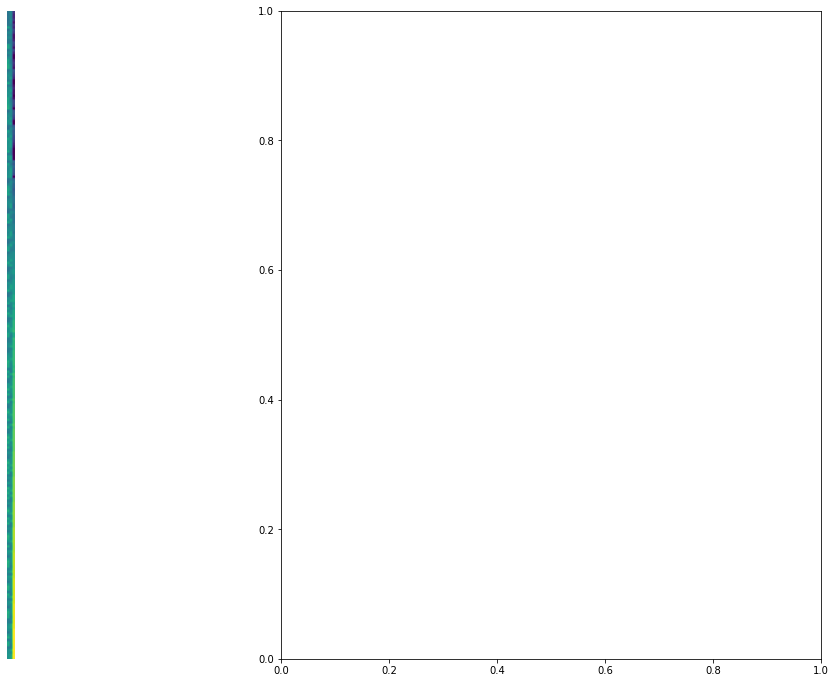

In [37]:
r2n2_renderings = r2n2_dataset[10,[1,2]]['verts'].unsqueeze(0)
print(r2n2_renderings.shape)
image_grid(r2n2_renderings.numpy(), rows=1, cols=2, rgb=True)


In [24]:
batch_size = 12
r2n2_single_view = R2N2("train", SHAPENET_PATH, R2N2_PATH, SPLITS_PATH, return_all_views=False, return_voxels=False)
r2n2_loader = DataLoader(r2n2_single_view, batch_size=batch_size, collate_fn=collate_batched_meshes)

 category    #instances
-----------  ------------
   sofa      2412
  cabinet    1195
   bench     1380
   chair     5149
  display    833
   rifle     1804
loudspeaker  1228
   lamp      1762
 telephone   799
 airplane    3075
   table     6460
    car      5698
watercraft   1473
   total     33268


torch.Size([12, 1, 137, 137, 3])


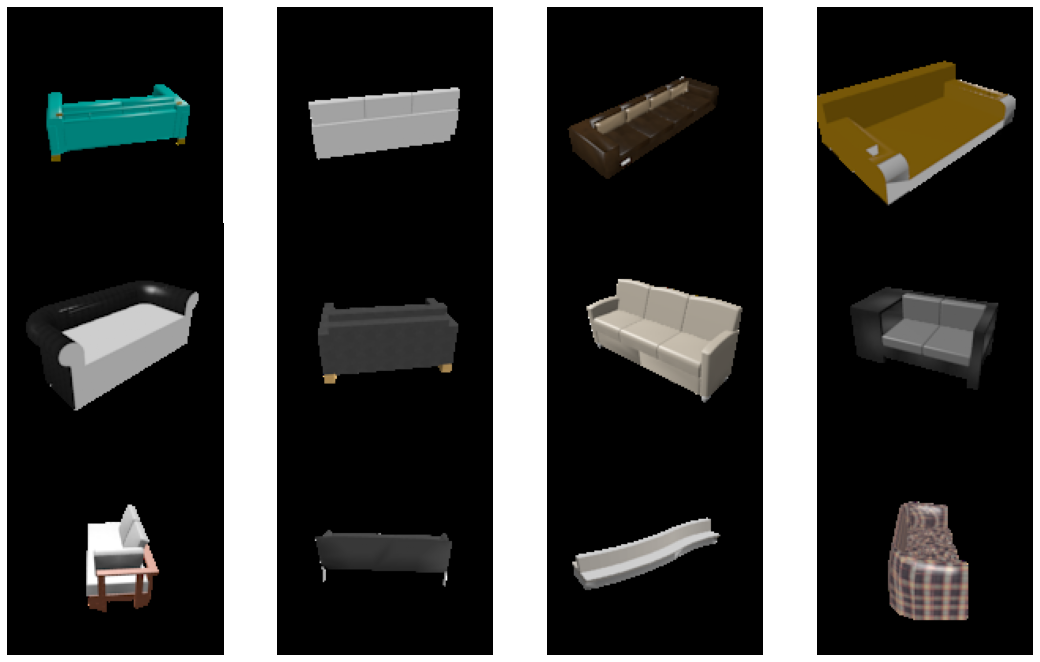

In [30]:
it = iter(r2n2_loader)
r2n2_batch = next(it)
batch_renderings = torch.stack(r2n2_batch["images"], dim=0) # (N, V, H, W, 3), and in this case V is 1.
print(batch_renderings.shape)
image_grid(batch_renderings.squeeze().numpy(), rows=3, cols=4, rgb=True)

In [48]:
# Rendering settings.
R, T = look_at_view_transform(1.0, 1.0, 90)
cameras = OpenGLPerspectiveCameras(R=R, T=T, device=device)
raster_settings = RasterizationSettings(image_size=512)
lights = PointLights(location=torch.tensor([0.0, 1.0, -2.0], device=device)[None],device=device)

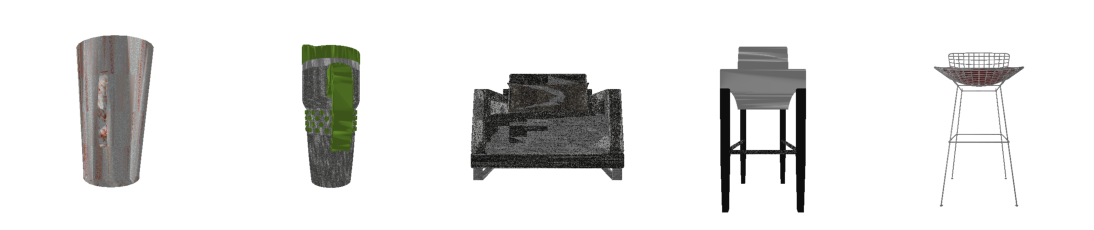

In [49]:
images_by_categories = shapenet_dataset.render(
    categories=["mug", "chair"],
    sample_nums=[2, 3],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_categories.cpu().numpy(), rows=1, cols=5, rgb=True)

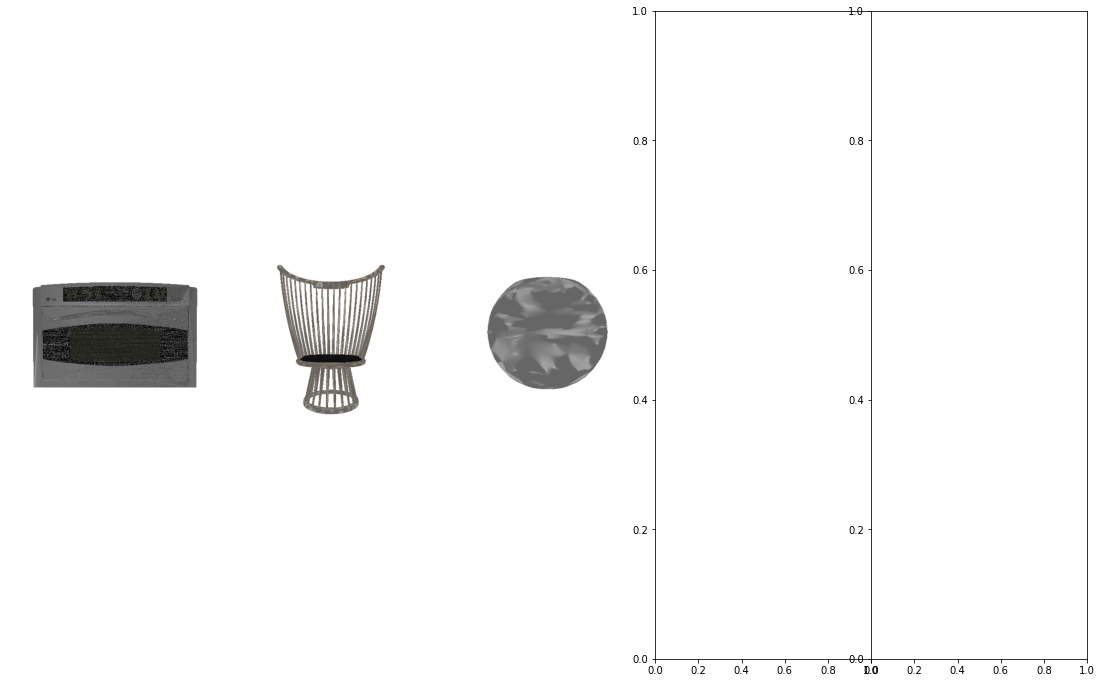

In [33]:
random_model_images = shapenet_dataset.render(
    sample_nums=[3],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(random_model_images.cpu().numpy(), rows=1, cols=5, rgb=True)

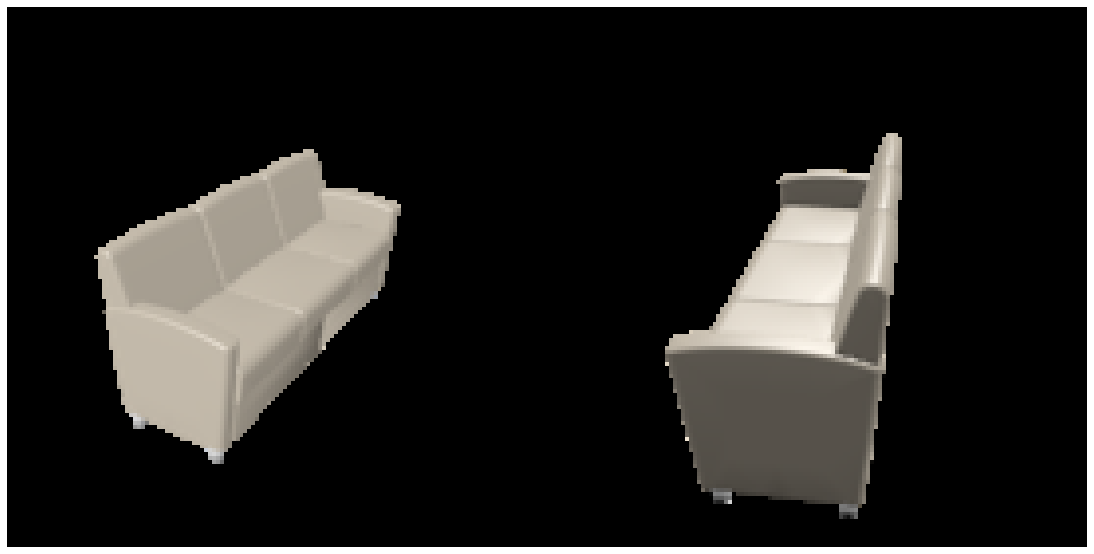

In [34]:
original_rendering = r2n2_dataset[6,[1,2]]["images"]
image_grid(original_rendering.numpy(), rows=1, cols=2, rgb=True)

In [36]:
r2n2_oriented_images = r2n2_dataset.render(
    idxs=[6],
    view_idxs=[1,2],
    device=device,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(r2n2_oriented_images.cpu().numpy(), rows=1, cols=2, rgb=True)

NotImplementedError: 

In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch3d.loss import chamfer
import pytorch3d.ops as ops 
import wandb
import torchvision.models as models

#model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
#model.eval()

resnet50 = models.resnet50(pretrained=True)


Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /Users/carolinechoi/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/carolinechoi/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def train(model, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()
train()